# LSTM을 이용한 Stabucks 주가 예측

## 라이브버리 임포트

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

## 데이터 로드 및 시각화

Device: cpu
(253, 6)
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


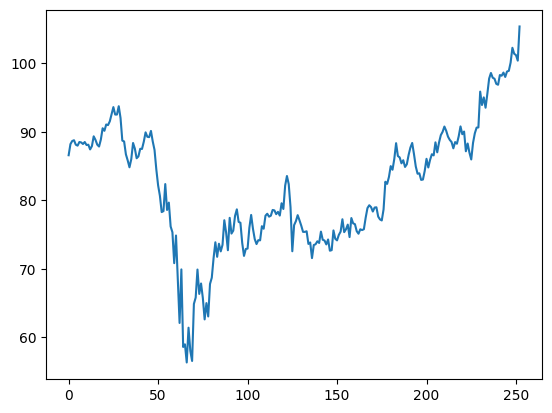

        Open       High        Low      Close
0  86.260002  86.870003  85.849998  86.589996
1  88.000000  88.889999  87.540001  88.209999
2  88.019997  88.790001  87.580002  88.669998
3  89.139999  89.300003  88.430000  88.779999
4  88.870003  88.970001  87.470001  88.129997
56.330002
105.389999


In [55]:
# CUDA가 사용 가능 한 경우 GPU를 사용, 그렇지 않다면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# 데이터 로드 및 시각화
sbux = pd.read_csv('SBUX.csv')
print(sbux.shape)
print(sbux.isnull().sum())

plt.plot(sbux['Close'], label = 'Starbucks Stock Price Data')
plt.show()

sbux = sbux.iloc[:,1:5]
print(sbux.head())
print(sbux['Close'].min())
print(sbux['Close'].max())

# 데이터 전처리

In [56]:
def sliding_windows(x_df, y_df, seq_length):
    x = []
    y = []

    for i in range(len(x_df)-seq_length-1):
        _x = x_df[i:(i+seq_length)]
        _y = y_df[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

scaler = MinMaxScaler()
scaler_sbux = scaler.fit_transform(sbux)

seq_length = 7

x_df = scaler_sbux[:, :3]
y_df = scaler_sbux[:, 3:4]

x, y = sliding_windows(x_df, y_df, seq_length)
print(x.shape,y.shape)

(245, 7, 3) (245, 1)


In [57]:
# fix random seed for reproducibility
torch.manual_seed(7)

train_size = int((3/4)*len(y))
test_size = len(y) - train_size

X_data = torch.Tensor(np.array(x))
Y_data = torch.Tensor(np.array(y))

X_data=X_data.to(device)
Y_data=Y_data.to(device)

X_train = torch.Tensor(np.array(x[0:train_size]))
Y_train = torch.Tensor(np.array(y[0:train_size]))

X_test = torch.Tensor(np.array(x[train_size:len(x)]))
Y_test = torch.Tensor(np.array(y[train_size:len(y)]))

X_train=X_train.to(device)
Y_train=Y_train.to(device)
X_test=X_test.to(device)
Y_test=Y_test.to(device)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

torch.Size([183, 7, 3]) torch.Size([183, 1])
torch.Size([62, 7, 3]) torch.Size([62, 1])


## 파라미터 지정

In [58]:
num_epochs = 1000
learning_rate = 0.01

input_size = 3
hidden_size = 32
num_layers = 2
num_classes = 1

## 모델 선언

In [59]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        # 모델 하이퍼파라미터 저장
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        # LSTM 레이어 정의
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        # Fully Connected Layer 정의
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # LSTM 초기 은닉 상태 (h_0)와 셀 상태 (c_0) 설정
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size,device=device)

        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size,device=device)

        # LSTM에 입력 데이터(x)와 초기 상태(h_0, c_0)를 전달
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))

        # LSTM 마지막 레이어의 은닉 상태(h_n[-1])를 추출
        h_n = h_n[-1]  # (batch_size, hidden_size)

        result = self.fc(h_n)

        return result

In [60]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm = lstm.to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(X_train)

    optimizer.zero_grad()

    # obtain the loss function
    loss = loss_function(outputs, Y_train)

    loss.backward()

    optimizer.step()
    if (epoch+1)== 1:
        print("Epoch: %d, loss: %1.5f" % (epoch+1, loss.item()))
    if (epoch+1) % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch+1, loss.item()))

Epoch: 1, loss: 0.12409
Epoch: 100, loss: 0.00239
Epoch: 200, loss: 0.00193
Epoch: 300, loss: 0.00184
Epoch: 400, loss: 0.00175
Epoch: 500, loss: 0.00171
Epoch: 600, loss: 0.00145
Epoch: 700, loss: 0.00127
Epoch: 800, loss: 0.00187
Epoch: 900, loss: 0.00092
Epoch: 1000, loss: 0.00085


## 예측

#### Predict #### [99.01584]
#### RMSE #### 1.504096


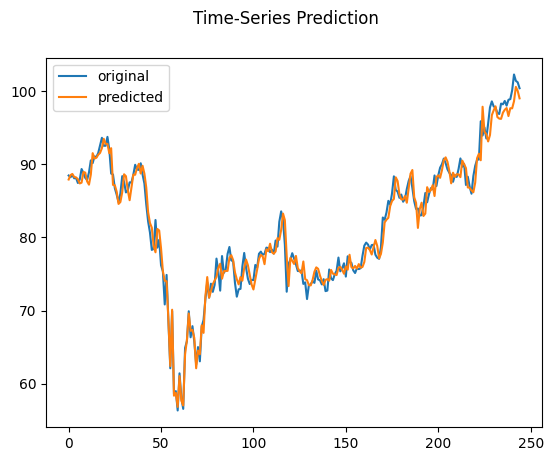

In [61]:
Y_predict = lstm(X_data)

last_sequence = X_data[-1, :, :]
last_sequence = last_sequence[np.newaxis, :, :]
next_pred = lstm(last_sequence)

Y_predict_n = Y_predict.data.cpu().numpy()
Y_data_n = Y_data.data.cpu().numpy()
next_pred_n = next_pred.data.cpu().numpy()

Y_pred_n = np.concatenate((Y_predict_n, next_pred_n), axis=0)

inverse_scaled_Y_predict = ((Y_predict_n * (sbux['Close'].max() - sbux['Close'].min())) + sbux['Close'].min())
inverse_scaled_Y_data = ((Y_data_n * (sbux['Close'].max() - sbux['Close'].min())) + sbux['Close'].min())

print('#### Predict ####', inverse_scaled_Y_predict[-1])

from sklearn.metrics import mean_squared_error
import numpy as np
mse_val=mean_squared_error(inverse_scaled_Y_predict, inverse_scaled_Y_data)
# mse_val=mean_squared_error(Y_predict_n, Y_data_n)
print('#### RMSE ####',np.sqrt(mse_val))

plt.plot(inverse_scaled_Y_data, label='original')
plt.plot(inverse_scaled_Y_predict,label='predicted' )
# plt.plot(Y_data_n, label='original')
# plt.plot(Y_predict_n,label='predicted' )
plt.suptitle('Time-Series Prediction')
plt.legend(loc='best')
plt.show()